# Fine-turn ASR based on Fosd dataset

- Dataset: FPT Open Speech Dataset (FOSD) - Vietnamese
- Link: https://data.mendeley.com/datasets/k9sxg2twv4/4

In [2]:
import torch
import torchaudio
import torchaudio.transforms as T
from dataclasses import dataclass
import evaluate

print(torch.__version__)
print(torchaudio.__version__)

ModuleNotFoundError: No module named 'evaluate'

## Preparation

In [3]:
DATA_DIR = "datasets/fosd/mp3/"
TRANSCRIPT_PATH = "datasets/fosd/transcriptAll.txt"

In [4]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

torch.random.manual_seed(0)

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)


## Load data to dataframe

In [5]:
import os
import pathlib
import pandas as pd

df = pd.read_csv(TRANSCRIPT_PATH, sep="|", header=None, names=["file_path", "text", "duration"])
df.head()

,file_path,text,duration
0,FPTOpenSpeechData_Set001_V0.1_000001.mp3,cách để đi,0.00000-1.27298
1,FPTOpenSpeechData_Set001_V0.1_000002.mp3,họ đã xét nghiệm máu cho cheng nhưng mọi thứ v...,0.00000-3.79298
2,FPTOpenSpeechData_Set001_V0.1_000003.mp3,anh có thể gọi tôi không,0.00000-2.52098
3,FPTOpenSpeechData_Set001_V0.1_000004.mp3,có rất nhiều yếu tố may rủi ở đây,0.00000-3.43298
4,FPTOpenSpeechData_Set001_V0.1_000005.mp3,ai là chúa nói dối,0.00000-3.93698


In [6]:
# add data path to file_path
df["file_path"] = DATA_DIR + df["file_path"]
df.head()

,file_path,text,duration
0,datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0....,cách để đi,0.00000-1.27298
1,datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0....,họ đã xét nghiệm máu cho cheng nhưng mọi thứ v...,0.00000-3.79298
2,datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0....,anh có thể gọi tôi không,0.00000-2.52098
3,datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0....,có rất nhiều yếu tố may rủi ở đây,0.00000-3.43298
4,datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0....,ai là chúa nói dối,0.00000-3.93698


## EDA

In [7]:
sample = df.sample(1).iloc[0]
waveform, sample_rate = torchaudio.load(sample["file_path"])
print(f"transcript: {sample['text']}")
Audio(waveform.numpy()[0], rate=sample_rate)

transcript: Khi tổng hợp , ta thấy rất đơn giản và rõ ràng .


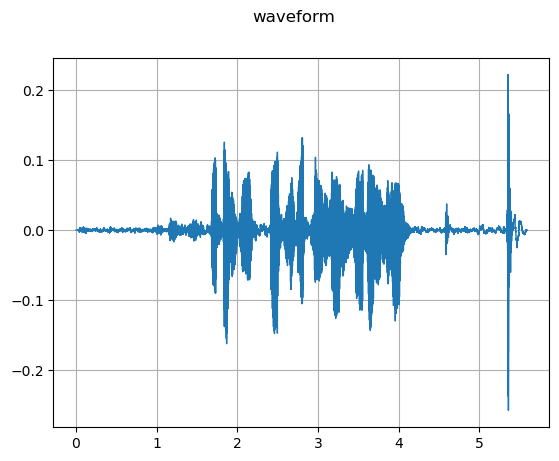

In [8]:
plot_waveform(waveform, sample_rate)

In [9]:
sample = df.sample(1).iloc[0]
waveform, sample_rate = torchaudio.load(sample["file_path"])
print(f"transcript: {sample['text']}")
Audio(waveform.numpy()[0], rate=sample_rate)

transcript: Tôi là thành viên mới , là đàn ông tham gia diễn đàn .


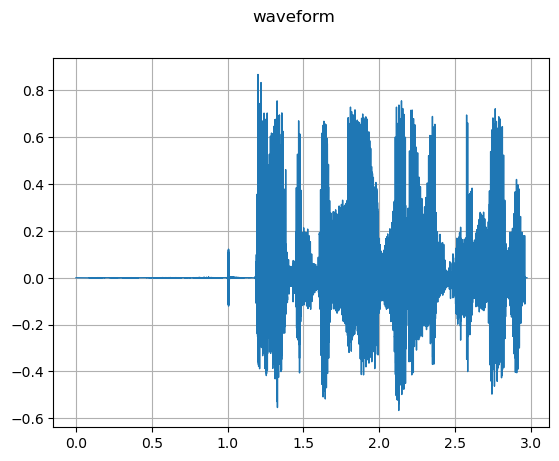

In [10]:
plot_waveform(waveform, sample_rate)

In [11]:
waveform

tensor([[ 0.0000e+00, -2.5951e-14, -1.0970e-13,  ..., -2.1508e-10,
          3.9561e-09,  8.1283e-09]])

## Create Dataset

In [12]:
from datasets import Dataset
from datasets import Audio

list_file_paths = df["file_path"].to_list()
list_transcript = df["text"].to_list()

audio_dataset = Dataset.from_dict(
    {
        "audio": list_file_paths,
        "sentence": list_transcript
    }
)
audio_dataset

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 25921
})

In [13]:
audio_dataset = audio_dataset.cast_column("audio", Audio())
audio_dataset[0]["audio"]

{'path': 'datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0.1_000001.mp3',
 'array': array([ 0.00000000e+00, -1.03963071e-11,  5.86073898e-12, ...,
         5.16566433e-06,  6.72358192e-06,  6.14662076e-06]),
 'sampling_rate': 48000}

In [14]:
audio_dataset[0]

{'audio': {'path': 'datasets/fosd/mp3/FPTOpenSpeechData_Set001_V0.1_000001.mp3',
  'array': array([ 0.00000000e+00, -1.03963071e-11,  5.86073898e-12, ...,
          5.16566433e-06,  6.72358192e-06,  6.14662076e-06]),
  'sampling_rate': 48000},
 'sentence': 'cách để đi'}

In [15]:
# Split dataset to training and testing
audio_dataset = audio_dataset.train_test_split(test_size=0.2)
audio_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 20736
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 5185
    })
})

## Feature Extractor, Tokenizer and Processor

In [16]:
from transformers.models.whisper.tokenization_whisper import TO_LANGUAGE_CODE
TO_LANGUAGE_CODE['english']

'en'

In [17]:
TO_LANGUAGE_CODE['vietnamese']

'vi'

In [18]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small", language="vietnamese", task="transcribe"
)

In [19]:
audio_dataset["train"].features

{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'sentence': Value(dtype='string', id=None)}

In [20]:
sampling_rate = processor.feature_extractor.sampling_rate
sampling_rate

16000

In [21]:
audio_dataset = audio_dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))
audio_dataset["train"].features

{'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'sentence': Value(dtype='string', id=None)}

In [22]:
def prepare_dataset(example):
    audio = example["audio"]
    
    example = processor(
        audio=audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=example["sentence"],
    )
    
    # compute input length of audio sample in seconds
    example["input_length"] = len(audio["array"]) / audio["sampling_rate"]
    
    return example

In [23]:
audio_dataset = audio_dataset.map(
    prepare_dataset, 
    remove_columns=audio_dataset.column_names["train"], 
    num_proc=6)

Map (num_proc=6):   0%|          | 0/20736 [00:00<?, ? examples/s]

In [ ]:
max_input_length = 30.0
def is_audio_in_length_range(length):
    return length < max_input_length

audio_dataset["train"] = audio_dataset["train"].filter(
    is_audio_in_length_range,
    input_columns=["input_length"],
)

audio_dataset["train"]